### driftkit

LLM-powered pyschogeographic exploration.

In [11]:
! pip3 install --quiet -r requirements.txt 

In [ ]:
! conda install -c conda-forge ffmpeg -y
# restart the kernel after installing ffmpeg

In [1]:
from dotenv import load_dotenv
import os

# Load the .env file
load_dotenv()

True

In [2]:
from typing import List

from langchain_core.tools import tool
from langchain_core.runnables.config import RunnableConfig

from langgraph.prebuilt import ToolNode

@tool(parse_docstring=True)
def navigate(
    from_lat: float,
    from_lon: float,
    location_id: str,
    config: RunnableConfig,
) -> None:
    """Navigate to a location.

    Args:
        location_id: ID of the location to navigate to.
    """
    navigator = config.get("configurable", {}).get("navigator")
    navigation_result = navigator.navigate(from_lat, from_lon, location_id)
    return {
            "tool_message": navigation_result["message"], 
            "current_location": navigation_result["current_location"],
            "walking_directions": navigation_result["walking_directions"]
            }

@tool
def get_next_possible_destinations(from_lat: float, from_lon: float, config: RunnableConfig) -> None:
    """Get next possible destinations."""
    navigator = config.get("configurable", {}).get("navigator")
    result = navigator.get_next_possible_destinations(from_lat, from_lon)
    
    if result["status"] == "complete":
        return {"tool_message": "Your route is complete. You have visited all possible locations."}

    if result["status"] != "success":
        return {"tool_message": "Failed to get next possible destinations."}
    
    destinations = result["destinations"]
    destinations_list = "\n".join([f"- {dest['name']} (ID: {dest['id']})" for dest in destinations])
    return {"tool_message": destinations_list}


tools = [navigate, get_next_possible_destinations]
tool_node = ToolNode(tools)

In [3]:
from langchain_anthropic import ChatAnthropic
from langgraph.graph import StateGraph, MessagesState
from langgraph.prebuilt import ToolNode

model = ChatAnthropic(model="claude-3-5-sonnet-20240620")
model_with_tools = ChatAnthropic(model="claude-3-5-sonnet-20240620").bind_tools(tools)

In [4]:
from typing import Literal, TypedDict, Annotated

from street_navigator import Location, RouteStep
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage

class MessagesStateWithLocation(MessagesState):
    start_location: str
    trip_summary: str
    max_locations: int
    current_location: Location = None
    visited_locations: List[Location]
    route: List[RouteStep]

def begin_walk(state: MessagesStateWithLocation, config: RunnableConfig):
    navigator = config.get("configurable", {}).get("navigator")
    new_route = navigator.start_route(state["start_location"])
    current_location_id = new_route["current_location"]["id"]
    return {
        "messages": [HumanMessage(content=f"You started your walk at {state['start_location']}.")],
        "current_location": new_route["current_location"],
        "visited_locations": [new_route["current_location"]]
    }

def should_continue(state: MessagesStateWithLocation):
    messages = state["messages"]

    if len(state["visited_locations"]) >= state["max_locations"]:
        return "summarize_journey"

    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    
    raise Exception("Should continue not implemented")

    return END

def update_state_from_tools(state: MessagesStateWithLocation, config: RunnableConfig):
    messages = state["messages"]
    last_message = messages[-1]
    
    # parse tool last_message string into dict
    import json
    content = json.loads(last_message.content)

    if "tool_message" in content and "current_location" in content:
        return {
                "messages": [HumanMessage(content=content["tool_message"])], 
                "visited_locations": state["visited_locations"] + [content["current_location"]],
                "current_location": content["current_location"],
                "route": state["route"] + content.get("walking_directions", [])
                }
    if "tool_message" in content:
        return {"messages": [HumanMessage(content=content["tool_message"])]}


def summarize_journey(state: MessagesStateWithLocation):
    visited_locations = state["visited_locations"]
    messages = [HumanMessage(content=f"You visited some cool places: {visited_locations}. Summarize your throughts and feelings about the journey in a short paragraph as a pyschogeographical report.")]
    response = model.invoke(messages)
    return {"trip_summary": response.content}

def call_model(state: MessagesStateWithLocation):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}

builder = StateGraph(MessagesStateWithLocation)

builder.add_node("begin_walk", begin_walk)
builder.add_node("agent", call_model)
builder.add_node("tools", tool_node)
builder.add_node("update_state_from_tools", update_state_from_tools)
builder.add_node("summarize_journey", summarize_journey)

builder.add_edge(START, "begin_walk")
builder.add_edge("begin_walk", "agent")
builder.add_conditional_edges("agent", should_continue, ["tools", "summarize_journey", END])
builder.add_edge("summarize_journey", END)
builder.add_edge("tools", "update_state_from_tools")
builder.add_edge("update_state_from_tools", "agent")

memory = MemorySaver()

graph = builder.compile(checkpointer=memory)

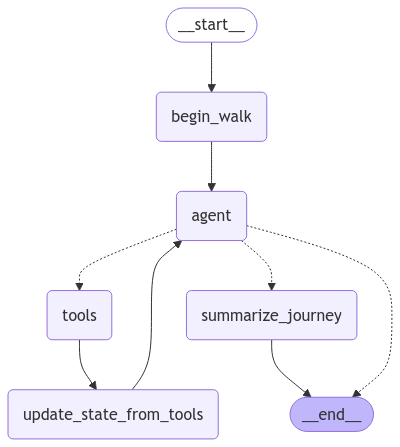

In [5]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [6]:
from langchain_core.messages import HumanMessage
from street_navigator import StreetNavigator

navigator = StreetNavigator(location_search_radius=500)

PROMPT = """You are an urban pyschogeographer and French radical theorist associated with the Situationist International.
Choose an interesting and inspiring route to explore, pay attention to the details.
A novel and unexpected next destination should be selected so that you can explore the city in a new way.
---
ALWAYS reflect as a pedestrian and urban explorer before choosing a new destination using the following format:
Novel destinations: [List of destinations]
Destinations different from previous ones: [List of destinations]
Destination that creates the most novel experience and interesting route: [Destination] [Destination ID].

DO NOT offer any other information about most novel destination after selecting one.
---
ALWAYS get a list of possible destinations before navigating to the next location.
"""

inputs = {"messages": [HumanMessage(content=PROMPT)], "max_locations": 4, "start_location": "1269 South Van Ness Ave, SF", "route": [], "visited_locations": []}

config = {"configurable": {"navigator": navigator, "thread_id": "1"}, "recursion_limit": 30}

# TODO: make navigator stateless and save route in graph
for chunk in graph.stream(
    inputs, config, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()



================================ Human Message =================================

You are an urban pyschogeographer and French radical theorist associated with the Situationist International.
Choose an interesting and inspiring route to explore, pay attention to the details.
A novel and unexpected next destination should be selected so that you can explore the city in a new way.
---
ALWAYS reflect as a pedestrian and urban explorer before choosing a new destination using the following format:
Novel destinations: [List of destinations]
Destinations different from previous ones: [List of destinations]
Destination that creates the most novel experience and interesting route: [Destination] [Destination ID].

DO NOT offer any other information about most novel destination after selecting one.
---
ALWAYS get a list of possible destinations before navigating to the next location.

================================ Human Message =================================

You started your walk at 1269 S

As I wandered through the vibrant Mission District of San Francisco, I felt a palpable sense of contrast and community. Beginning near South Van Ness Avenue, I was drawn to the artistic energy emanating from Dance Mission Theater, where creativity and cultural expression thrive. The journey took an interesting turn as I passed by the Social Security Administration, a stark reminder of bureaucracy amidst the neighborhood's bohemian spirit. The low rating of this government office seemed to reflect a collective frustration with institutional systems. Finally, ending at City Beer Store, I sensed a return to the area's more convivial atmosphere, where craft brews and good food bring people together. This psychogeographical journey highlighted the Mission's ability to encompass diverse experiences – from artistic passion to civic engagement to social enjoyment – all within a few city blocks.
[{'id': '', 'name': 'Start Location', 'coordinates': {'lat': 37.7528714, 'lon': -122.4161472}, 'addr

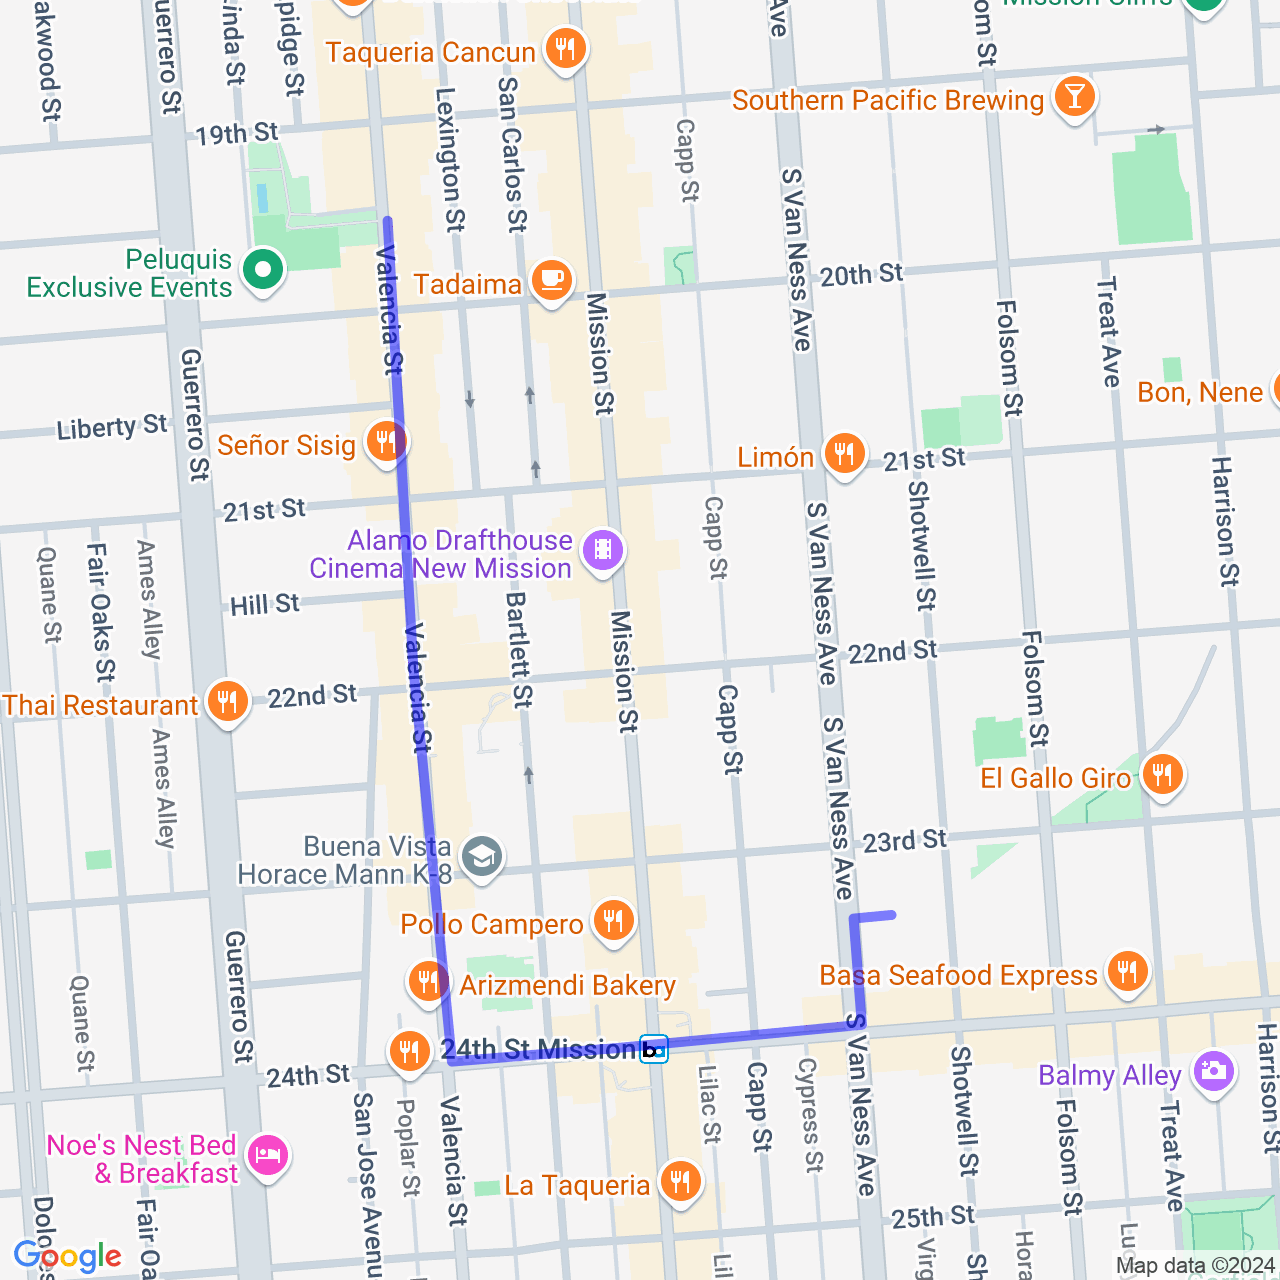

In [7]:
from route_visualizer import visualize_route

trip_summary = graph.get_state(config).values["trip_summary"]
visited_locations = graph.get_state(config).values["visited_locations"]
print(trip_summary)

print(visited_locations)

visualize_route(graph.get_state(config).values["route"])

In [8]:
import os
import requests
import numpy as np
from PIL import Image
import io
from moviepy.editor import ImageSequenceClip, AudioFileClip, CompositeVideoClip, VideoFileClip
from moviepy.config import change_settings
from openai import OpenAI
import time
from typing import List, Dict
import math
from dotenv import load_dotenv
import subprocess
import cv2
from scipy.ndimage import gaussian_filter

# Load environment variables
load_dotenv()

class StreetMontageCreator:
    def __init__(self, api_key: str = None, openai_api_key: str = None):
        self._check_ffmpeg()
        
        self.api_key = api_key or os.getenv("GMAPS_API_KEY")
        if not self.api_key:
            raise ValueError("Google Maps API key is required")
            
        openai_key = openai_api_key or os.getenv("OPENAI_API_KEY")
        if not openai_key:
            raise ValueError("OpenAI API key is required")
            
        self.openai_client = OpenAI(api_key=openai_key)
        self.temp_dir = "temp_montage"
        os.makedirs(self.temp_dir, exist_ok=True)
        self.DEFAULT_FPS = 30.0

    def _check_ffmpeg(self):
        try:
            conda_ffmpeg = os.path.join(os.environ.get('CONDA_PREFIX', ''), 'bin', 'ffmpeg')
            if os.path.exists(conda_ffmpeg):
                change_settings({"FFMPEG_BINARY": conda_ffmpeg})
                return
            
            result = subprocess.run(['which', 'ffmpeg'], capture_output=True, text=True)
            if result.returncode == 0:
                ffmpeg_path = result.stdout.strip()
                change_settings({"FFMPEG_BINARY": ffmpeg_path})
                return
            
            raise FileNotFoundError("ffmpeg not found")
        except Exception as e:
            raise RuntimeError(
                "ffmpeg not found. Please install it using:\n"
                "conda: conda install ffmpeg\n"
                "ubuntu: sudo apt-get install ffmpeg\n"
                "macos: brew install ffmpeg"
            ) from e

    def _get_street_view_image(self, lat: float, lon: float, heading: float = 0) -> Image.Image:
        base_url = "https://maps.googleapis.com/maps/api/streetview"
        params = {
            "size": "1280x720",
            "location": f"{lat},{lon}",
            "heading": heading,
            "pitch": "0",
            "outside": "true",
            "key": self.api_key
        }
        
        response = requests.get(base_url, params=params)
        if response.status_code == 200:
            return Image.open(io.BytesIO(response.content))
        else:
            raise Exception(f"Failed to fetch Street View image: {response.status_code}")

    def _create_voiceover(self, script: str, output_path: str) -> float:
        response = self.openai_client.audio.speech.create(
            model="tts-1",
            voice="onyx",
            response_format="aac",
            input=script
        )
        
        response.stream_to_file(output_path)
        
        audio = AudioFileClip(output_path)
        duration = float(audio.duration)
        audio.close()
        
        return duration

    def apply_psychedelic_filter(self, image: np.ndarray, intensity: float = 1.0) -> np.ndarray:
        """
        Apply a psychedelic filter to an image.
        
        Args:
            image: Input image as numpy array
            intensity: Filter intensity (0.0 to 1.0)
            
        Returns:
            Filtered image as numpy array
        """
        # Convert to float for processing
        img_float = image.astype(float) / 255.0
        
        # Split into channels
        b, g, r = cv2.split(img_float)
        
        # Apply color shifting
        r_shift = np.roll(r, int(25 * intensity), axis=1)
        b_shift = np.roll(b, int(-25 * intensity), axis=1)
        
        # Edge enhancement
        edges = cv2.Canny(image, 100, 200)
        edges_float = edges.astype(float) / 255.0
        edges_blurred = gaussian_filter(edges_float, sigma=2)
        
        # Create glowing edges
        glow = gaussian_filter(edges_float, sigma=5)
        
        # Combine channels with shifted colors and glowing edges
        result = cv2.merge([
            np.clip(b_shift + glow * 0.3 * intensity, 0, 1),
            np.clip(g + edges_blurred * 0.5 * intensity, 0, 1),
            np.clip(r_shift + glow * 0.3 * intensity, 0, 1)
        ])
        
        # Add slight color boost
        result = np.clip(result * 1.2, 0, 1)
        
        # Convert back to uint8
        return (result * 255).astype(np.uint8)

    # Add this to the StreetMontageCreator class
    def _apply_psychedelic_effects(self, images: List[np.ndarray], fps: float) -> List[np.ndarray]:
        """
        Apply psychedelic effects to a sequence of images.
        
        Args:
            images: List of input images
            fps: Frames per second
            
        Returns:
            List of processed images
        """
        processed_images = []
        frame_count = len(images)
        
        for i, image in enumerate(images):
            # Calculate pulsing intensity based on frame position
            time_position = i / fps
            intensity = 0.5 + 0.3 * np.sin(2 * np.pi * time_position)
            
            # Apply the psychedelic filter
            processed = self.apply_psychedelic_filter(image, intensity)
            processed_images.append(processed)
            
        return processed_images

    def create_montage(self, locations: List[Dict], script: str, output_path: str, fps: float = None) -> None:
        fps = float(fps) if fps is not None else float(self.DEFAULT_FPS)
        print(f"Starting video creation with fps: {fps}")
        
        if not locations:
            raise ValueError("At least one location is required")

        # Create temporary files
        temp_video = os.path.join(self.temp_dir, "temp_video.mp4")
        audio_path = os.path.join(self.temp_dir, "voiceover.aac")
        
        try:
            # Generate voiceover first
            duration = self._create_voiceover(script, audio_path)
            print(f"Generated voiceover with duration: {duration}")

            # Calculate frames needed
            total_frames = int(math.ceil(duration * fps))
            frames_per_location = max(1, total_frames // len(locations))
            print(f"Total frames needed: {total_frames}, frames per location: {frames_per_location}")

            # Generate images
            images = []
            for location in locations:
                lat = None
                lon = None

                if 'lat' in location['coordinates'] and 'lon' in location['coordinates']:
                    lat = location['coordinates']['lat']
                    lon = location['coordinates']['lon']
                
                if 'latitude' in location['coordinates'] and 'longitude' in location['coordinates']:
                    lat = location['coordinates']['latitude']
                    lon = location['coordinates']['longitude']

                if lat is None or lon is None:
                    raise ValueError("Latitude and longitude are required for each location")

                for frame in range(frames_per_location):
                    heading = (360 / frames_per_location) * frame
                    try:
                        image = self._get_street_view_image(lat, lon, heading)
                        images.append(np.array(image))
                    except Exception as e:
                        print(f"Error fetching image for location {location['name']}: {e}")
                        if images:
                            images.append(images[-1].copy())
                        else:
                            images.append(np.zeros((720, 1280, 3), dtype=np.uint8))
                    time.sleep(0.1)

            # Ensure we have enough frames
            while len(images) < total_frames:
                images.append(images[-1].copy())
            images = images[:total_frames]
            
            print(f"Generated {len(images)} images")

            # Apply psychedelic effects
            print("Applying psychedelic effects...")
            images = self._apply_psychedelic_effects(images, fps)

            # Create video without audio first
            print("Creating video clip...")
            video = ImageSequenceClip(images, fps=fps)
            if not hasattr(video, 'fps') or video.fps is None:
                video.fps = fps
            print(f"Video clip created with fps: {video.fps}")

            # Write temporary video file
            print("Writing temporary video file...")
            video.write_videofile(
                temp_video,
                fps=fps,
                codec='libx264',
                audio=False,
                verbose=False
            )

            # Load the video and audio separately
            print("Loading video and audio for final composition...")
            video_clip = VideoFileClip(temp_video)
            audio_clip = AudioFileClip(audio_path)

            # Set the video duration to match the audio
            video_clip = video_clip.set_duration(audio_clip.duration)

            # Combine video and audio
            print("Creating final video with audio...")
            final_clip = video_clip.set_audio(audio_clip)
            
            # Write final video
            print(f"Writing final video to {output_path}...")
            final_clip.write_videofile(
                output_path,
                fps=fps,
                codec='libx264',
                audio_codec='aac',
                temp_audiofile=os.path.join(self.temp_dir, "temp_audio.aac"),
                remove_temp=True,
                verbose=False
            )

            print("Video creation completed successfully!")

        except Exception as e:
            raise Exception(f"Error creating video: {str(e)}")
            
        finally:
            # Cleanup
            for file in [temp_video, audio_path]:
                if os.path.exists(file):
                    try:
                        os.remove(file)
                    except:
                        pass

In [9]:
creator = StreetMontageCreator()
creator.create_montage(
    locations=visited_locations,
    script=trip_summary,
    output_path="street_montage.mp4",
    fps=3.0
)

Starting video creation with fps: 3.0
Generated voiceover with duration: 54.7
Total frames needed: 165, frames per location: 41
Generated 165 images
Applying psychedelic effects...
Creating video clip...
Video clip created with fps: 3.0
Writing temporary video file...
Moviepy - Building video temp_montage/temp_video.mp4.
Moviepy - Writing video temp_montage/temp_video.mp4



Moviepy - Done !
Moviepy - video ready temp_montage/temp_video.mp4
Loading video and audio for final composition...
Creating final video with audio...
Writing final video to street_montage.mp4...
Moviepy - Building video street_montage.mp4.
MoviePy - Writing audio in temp_montage/temp_audio.aac


MoviePy - Done.
Moviepy - Writing video street_montage.mp4



Moviepy - Done !
Moviepy - video ready street_montage.mp4
Video creation completed successfully!
